In [1]:
# Connect to MongoDB
import pymongo
from pymongo import MongoClient

# Connect to the localhost client
client = MongoClient()

# Get the petfinder database
db = client.petfinder_database
collection = db.pets

In [2]:
# Total size of the collection.
collection.estimated_document_count()

135440

In [3]:
# Total size of collection without an image
collection.count_documents({"url_img":{"$eq":""}})

6295

In [4]:
# Store collection into Pandas DataFrame
import pandas as pd
# Set ipython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)

query = {}
cursor = collection.find(query)
df =  pd.DataFrame(list(cursor))
# Delete the _id
del df['_id']

df.head(4)
df.size
df[0:1]

,age,breed,desc,gender,id,state,type,url,url_img
0,Puppy,Bullmastiff,"MO - Bandit, adoptable Dog, Puppy Male Bullma...",Male,41500599,MO,Dog,https://www.petfinder.com/dog/mo-bandit-415005...,https://dl5zpyw5k3jeb.cloudfront.net/photos/pe...


In [5]:
df1 = df.groupby(["type"] ).size().to_frame(name = 'count').reset_index()

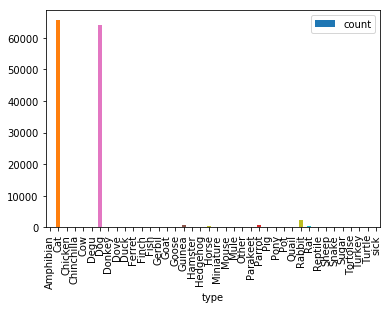

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
df1.plot(kind='bar', y='count', x='type')

In [7]:
df1 = df.groupby(["type"] ).size().to_frame(name = 'count').reset_index()

In [8]:
# Explore the description
df2 = df["desc"]
df2.head()

0    MO  - Bandit, adoptable Dog, Puppy Male Bullma...
1    Axel, adoptable Cat, Kitten Male Domestic Shor...
2    Art, adoptable Cat, Kitten Male Domestic Short...
3    Alf, adoptable Cat, Kitten Male Domestic Short...
4    Ari, adoptable Cat, Kitten Male Domestic Short...
Name: desc, dtype: object

In [9]:
import re

def substitute(keywords):
    rep = {
        "&": "and",
        "(": "",
        ")": "",
        "/":"",
        "'":"",
        ".":"",
        "`":"",
        ",":""
    }
    rep = dict((re.escape(k), v) for k, v in rep.items())
    pattern = re.compile("|".join(rep.keys()))
    
    return pattern.sub(lambda m: rep[re.escape(m.group(0))], keywords)

In [10]:
agg_type = set()
agg_breed = set()

def desc_parse(record):
    keyword = 'adoptable '
    before_keyword, keyword, after_keyword = record.partition(keyword)
    # clean and sanitize the string
    clean = substitute(after_keyword)
    split = clean.split(' ')
    
    # First Record is Type of Pet
    pet_type = split[0]
    
    # Second Record is the Age
    age = split[1]
    
    # Third record is the Gender
    gender = split[2]
    
    # Records are Breed
    breed = " ".join(split[3:])
    
    agg_type.add(pet_type)
    agg_breed.add(breed)
    
    return pet_type, age, gender, breed
    
    
df2.apply(desc_parse)
# print("-- Types --")
print(agg_type)
print("-- Breeds --")
print(len(agg_breed))
# agg_breed

{'Hamster', 'Finch', 'Guinea', 'Turtle', 'Pig', 'Parrot', 'Amphibian', 'Pot', 'Donkey', 'Ferret', 'Cat', 'Degu', 'Rat', 'Duck', 'Fish', 'Pony', 'Chicken', 'Other', 'Dog', 'Mule', 'Miniature', 'sick', 'Reptile', 'Goat', 'Sheep', 'Cow', 'Snake', 'Parakeet', 'Turkey', 'Gerbil', 'Dove', 'Horse', 'Mouse', 'Chinchilla', 'Rabbit', 'Hedgehog', 'Goose', 'Tortoise', 'Sugar', 'Quail'}
-- Breeds --
4561


In [11]:
def requestImage(src):
    uu = str(uuid.uuid4())
    req = urllib.request.Request(
        src,
        data=None,
        headers={
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/542.36'
        }
    )
    with urllib.request.urlopen(req) as response, open('./img-dog/'+uu+'.jpg', 'wb') as out_file:
        shutil.copyfileobj(response, out_file)

    return uu

In [12]:
collection.count_documents({"type":"CAT","url_img":{"$ne":""}})

0

In [13]:
# Create a CSV file with image URIs and labels
import csv
f = open('dogs__labels.csv', 'w')
with f:
    fieldnames = ['pet']
    writer = csv.DictWriter(f, fieldnames=fieldnames, quoting = csv.QUOTE_NONE, delimiter='|', quotechar='')
    writer.writeheader()
    
#     for doc in collection.find({"type":"DOG","state":"MO", "url_img":{"$ne":""}}).limit( 1244 ):
    for doc in collection.find({"type":"DOG","state":"MO", "url_img":{"$ne":""}}).limit( 1244 ):
        pet_type, age, gender, breed = desc_parse(doc['desc'])

        base_str = "gs://ociautomltest-vcm/{0}.jpg,{1}"
    
#         entry = base_str.format(doc['id'], breed.replace(" ", "_"))
        entry = base_str.format(doc['id'], "DOG")
        
        writer.writerow({'pet': entry})
#         writer.writerow(entry)
#     requestImage(doc['url_img'])
# CSV Format
# gs://ociautomltest-vcm/flowers/images/5217892384_3edce91761_m.jpg,dandelion,tulip,rose

In [14]:
# Create a new DataFrame for the agg_breed
df_breed = pd.DataFrame(list(agg_breed),columns=['breed'])
df_breed.size
df_breed.head()
# df_breed.info

#List unique values in the df['name'] column

num_breeds = df_breed.breed.unique()
len(num_breeds)

df_breed[df_breed['breed'] == "Beagle"]
# df_breed.head(4561)
# df_breed.plot(kind='line', x='breed')

,breed
3495,Beagle


## Topic Modeling with Scikit Learn
Latent Dirichlet Allocation (LDA) is a algorithms used to discover the topics that are present in a corpus. A few open source libraries exist, but if you are using Python then the main contender is Gensim. Gensim is an awesome library and scales really well to large text corpuses. Gensim, however does not include Non-negative Matrix Factorization (NMF), which can also be used to find topics in text. The mathematical basis underpinning NMF is quite different from LDA. I have found it interesting to compare the results of both of the algorithms and have found that NMF sometimes produces more meaningful topics for smaller datasets. NMF has been included in Scikit Learn for quite a while but LDA has only recently (late 2015) been included. The great thing about using Scikit Learn is that it brings API consistency which makes it almost trivial to perform Topic Modeling using both LDA and NMF. Scikit Learn also includes seeding options for NMF which greatly helps with algorithm convergence and offers both online and batch variants of LDA.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

documents = agg_breed

no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

no_topics = 20

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

no_top_words = 3
display_topics(nmf, tfidf_feature_names, no_top_words)
print('-----')
display_topics(lda, tf_feature_names, no_top_words)

## Enrich MongoDB collection per document

In [ ]:
import time
cursor = collection.find({},no_cursor_timeout=True)
for record in cursor:
    parsed = desc_parse(record['desc'])
# COMMENTED FOR POSTERITY
#     collection.update_one({
#       '_id': record['_id']
#     },{
#       '$set': {
#         'type': parsed[0],
#         'age': parsed[1],
#         'gender': parsed[2],
#         'breed': parsed[3]
#       }
#     }, upsert=False)
    
  
    
#     return pet_type, age, gender, breed
    # do stuff with your record

In [ ]:
from IPython.display import display, HTML, Image
Image(url='https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/41584293/1/?bust=1525796970&width=300')

# Rottweiler
cursor = collection.find({'breed':'Rottweiler'},no_cursor_timeout=True)
# for record in cursor:
#     print(record)
#     Image(url=record['url_img'])
    
#     display(HTML('''<img href="https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/41734833/1/?bust=1527380514&width=300">'''))
    

In [25]:
import re
REGEX = ".*Mix.*"
QUERY = {"type":"Dog","breed":{'$not':re.compile(REGEX)},"url_img":{"$ne":""}}
cursor = collection.find(QUERY,no_cursor_timeout=True)

for c in cursor:
    print(c['desc'])

MO  - Bandit, adoptable Dog, Puppy Male Bullmastiff
Cornbread, adoptable Dog, Adult Male Pit Bull Terrier
Spongebob, adoptable Dog, Adult Male Rottweiler
Bon Scott, adoptable Dog, Young Male Pit Bull Terrier
Hades, adoptable Dog, Adult Male American Bulldog
Mufasa, adoptable Dog, Young Male Pit Bull Terrier
Thunder McQueen, adoptable Dog, Adult Female Pit Bull Terrier
Logan, adoptable Dog, Adult Male Pit Bull Terrier
Rosenthal, adoptable Dog, Puppy Male Shepherd
Missoni, adoptable Dog, Puppy Female Shepherd
May, adoptable Dog, Adult Female Labrador Retriever
Andre, adoptable Dog, Young Male Shepherd
Benelli, adoptable Dog, Adult Male Pit Bull Terrier
Fresco, adoptable Dog, Adult Male Pit Bull Terrier
Maude, adoptable Dog, Adult Female Pit Bull Terrier
KAREEM, adoptable Dog, Young Male Labrador Retriever
Basil Bindi, adoptable Dog, Adult Female Yorkshire Terrier Yorkie
Moe Moe, adoptable Dog, Young Male Poodle
Peggy & Brianna, adoptable Dog, Senior Female Schnauzer
New Yorkie, adoptable

Bruno, adoptable Dog, Senior Male English Bulldog
Barney, adoptable Dog, Adult Male English Bulldog
Lucy, adoptable Dog, Senior Female English Bulldog
Link, adoptable Dog, Adult Male English Bulldog
Maxwell, adoptable Dog, Adult Male English Bulldog
Maxx, adoptable Dog, Adult Male English Bulldog
Rufus, adoptable Dog, Adult Male English Bulldog
Bennie, adoptable Dog, Adult Male English Bulldog
Bonnie, adoptable Dog, Senior Female English Bulldog
Clyde, adoptable Dog, Senior Male English Bulldog
Daisy Mae, adoptable Dog, Adult Female English Bulldog
Nova, adoptable Dog, Young Female Labrador Retriever
Bailey, adoptable Dog, Young Female Labrador Retriever
Zeus, adoptable Dog, Senior Male Chihuahua
Digger, adoptable Dog, Senior Male Beagle
Arthur, adoptable Dog, Adult Male Labrador Retriever
Boss, adoptable Dog, Young Male Pit Bull Terrier
ANDREW, adoptable Dog, Young Male Pit Bull Terrier
A644746, adoptable Dog, Adult Female Pit Bull Terrier
A644834, adoptable Dog, Young Female Pit Bull

Hercules, adoptable Dog, Adult Male Pit Bull Terrier
MISSY, adoptable Dog, Adult Female Poodle
ADDY, adoptable Dog, Puppy Female Shih Tzu
10K, adoptable Dog, Puppy Male Shih Tzu
AXEL, adoptable Dog, Adult Male Yorkshire Terrier Yorkie
PLUTO, adoptable Dog, Puppy Male Smooth Collie
MARS, adoptable Dog, Puppy Female Smooth Collie
SHADOW, adoptable Dog, Adult Male Pomeranian
HARVEY, adoptable Dog, Adult Male Komondor
Pearl, adoptable Dog, Adult Female Pit Bull Terrier
Jarod, adoptable Dog, Young Male American Staffordshire Terrier
Suzette, adoptable Dog, Adult Female Rat Terrier
Brownie, adoptable Dog, Adult Male Rat Terrier
Sasha, adoptable Dog, Adult Female Pit Bull Terrier
Eyota, adoptable Dog, Puppy Female Labrador Retriever
Angus, adoptable Dog, Young Male Boxer
Lilly, adoptable Dog, Young Female Dachshund
Pierre, adoptable Dog, Adult Male Poodle
Champagne, adoptable Dog, Adult Male Poodle
Missy, adoptable Dog, Young Female Border Collie
Chase, adoptable Dog, Young Male German Shephe

Paco, adoptable Dog, Adult Male Yellow Labrador Retriever
Maggie #3, adoptable Dog, Young Female Black Labrador Retriever
Leo, adoptable Dog, Adult Male Black Labrador Retriever
Deeogee & Maggie #2, adoptable Dog, Adult Male Yellow Labrador Retriever
Hudson MD, adoptable Dog, Young Male Boxer
Emma, adoptable Dog, Young Female Yellow Labrador Retriever
Willie, adoptable Dog, Adult Male Labrador Retriever
Kirby, adoptable Dog, Adult Male Beagle
Jango- Courtesy Listing, adoptable Dog, Adult Male American Bulldog
KGAC Shelter Smoke, adoptable Dog, Adult Male Pit Bull Terrier
18-1580 Skittles, adoptable Dog, Adult Male Australian Cattle Dog / Blue Heeler
Toby 18-1521, adoptable Dog, Senior Male Jack Russell Terrier
Jasper- Courtesy Listing, adoptable Dog, Young Male Pit Bull Terrier
Baybee- Courtesy Listing, adoptable Dog, Adult Female Pit Bull Terrier
Buffy- Courtesy Listing, adoptable Dog, Adult Female Pit Bull Terrier
Stafford Shelter Fireball, adoptable Dog, Young Male Pit Bull Terrier


1802-0446 Hemingway, adoptable Dog, Adult Male Pit Bull Terrier
1803-1637 Charlotte, adoptable Dog, Adult Female Pit Bull Terrier
Pom-pei, adoptable Dog, Adult Male Shar Pei
1803-1698 Twizzle, adoptable Dog, Adult Female Pit Bull Terrier
1806-1620 Vittoria, adoptable Dog, Adult Female Pit Bull Terrier
1801-0346 Bibimbap, adoptable Dog, Adult Male Pit Bull Terrier
1712-0370 Ruby, adoptable Dog, Senior Female Pit Bull Terrier
Barry, adoptable Dog, Adult Male Black Labrador Retriever
Ryan, adoptable Dog, Young Male Yellow Labrador Retriever
WD, adoptable Dog, Young Male Bull Terrier
MONROE, adoptable Dog, Adult Female Staffordshire Bull Terrier
PATIENCE, adoptable Dog, Young Female Pit Bull Terrier
REIGN, adoptable Dog, Young Female Pit Bull Terrier
JINNY, adoptable Dog, Adult Female Pit Bull Terrier
DIESEL, adoptable Dog, Adult Male Labrador Retriever
DAISY, adoptable Dog, Adult Female American Bulldog
Asia, adoptable Dog, Senior Female Japanese Chin
Jase, adoptable Dog, Adult Male Yorks

{{urgent}} Molly, adoptable Dog, Adult Female Pit Bull Terrier
Colt, adoptable Dog, Adult Male German Shepherd Dog
Jake, adoptable Dog, Adult Male Labrador Retriever
Dillon, adoptable Dog, Adult Male Rottweiler
JERRY, adoptable Dog, Adult Male Chihuahua
DOLLY, adoptable Dog, Adult Female Pit Bull Terrier
BROOKLYN, adoptable Dog, Adult Female Pit Bull Terrier
FRECKLES, adoptable Dog, Adult Male Labrador Retriever
CHASE, adoptable Dog, Adult Male Pit Bull Terrier
FRED, adoptable Dog, Senior Male Fox Terrier
PICASSO, adoptable Dog, Adult Male Siberian Husky
Ace, adoptable Dog, Adult Male Catahoula Leopard Dog
Honey #29, adoptable Dog, Adult Female Yellow Labrador Retriever
Eider, adoptable Dog, Adult Male Chocolate Labrador Retriever
Jeremiah #3, adoptable Dog, Adult Male Chocolate Labrador Retriever
Coco #33, adoptable Dog, Senior Female Chocolate Labrador Retriever
Calvin #9, adoptable Dog, Adult Male Yellow Labrador Retriever
Buddy #77, adoptable Dog, Young Male Yellow Labrador Retriev

Bella, adoptable Dog, Adult Female German Shepherd Dog
Nala, adoptable Dog, Young Female Mastiff
Bristol, adoptable Dog, Young Female Mastiff
King, adoptable Dog, Young Male Mastiff
Brenen, adoptable Dog, Young Male Mastiff
Eddy, adoptable Dog, Young Male Mastiff
Maddie, adoptable Dog, Young Female Mastiff
Marie Claire, adoptable Dog, Adult Female Poodle
Uma, adoptable Dog, Young Female Mastiff
Simon, adoptable Dog, Young Male Mastiff
Ralph, adoptable Dog, Young Male Mastiff
Jack, adoptable Dog, Young Male Great Dane
April, adoptable Dog, Young Female German Shepherd Dog
Tilly, adoptable Dog, Young Female German Shepherd Dog
Rhea, adoptable Dog, Young Female Mastiff
Harley, adoptable Dog, Adult Female Mastiff
Maxi, adoptable Dog, Young Male German Shepherd Dog
Max and Icess, adoptable Dog, Young Male Rottweiler
Zeus, adoptable Dog, Young Male Mastiff
Marie, adoptable Dog, Young Female German Shepherd Dog
Donny, adoptable Dog, Young Male German Shepherd Dog
Baloo, adoptable Dog, Young M

Daisy, adoptable Dog, Adult Female Bloodhound
Hercules, adoptable Dog, Adult Male Basset Hound
Waffles, adoptable Dog, Senior Male Basset Hound
Petunia, adoptable Dog, Young Female American Staffordshire Terrier
Bolillo, adoptable Dog, Adult Male Pug
Jude, adoptable Dog, Young Male Dutch Shepherd
LOUISE, adoptable Dog, Young Female Saint Bernard / St. Bernard
ZOEY, adoptable Dog, Young Female Saint Bernard / St. Bernard
DAISY, adoptable Dog, Young Female Saint Bernard / St. Bernard
Rita Hayworth, adoptable Dog, Young Female Keeshond
Jeri, adoptable Dog, Young Male Terrier
Sherlock, adoptable Dog, Young Male Dalmatian
Lala, adoptable Dog, Puppy Female Boxer
Gidbit, adoptable Dog, Adult Male Schnauzer
Casper, adoptable Dog, Young Male American Bulldog
Isobel 'Izzy', adoptable Dog, Adult Female Pit Bull Terrier
Ginger, adoptable Dog, Senior Female American Staffordshire Terrier
Tyga, adoptable Dog, Adult Male Pit Bull Terrier
Casper, adoptable Dog, Young Male Dalmatian
Lexi, adoptable Dog

Nino, adoptable Dog, Adult Male Pharaoh Hound
Larry, adoptable Dog, Young Male Newfoundland Dog
Scooby, adoptable Dog, Adult Male Great Dane
Chief, adoptable Dog, Adult Male South Russian Ovtcharka
Jetter, adoptable Dog, Adult Male Weimaraner
Tasha, adoptable Dog, Senior Female Alaskan Malamute
Solitario, adoptable Dog, Senior Male Boxer
Anna, adoptable Dog, Senior Female Bloodhound
Mimi, adoptable Dog, Young Female Great Dane
Troy, adoptable Dog, Adult Male Weimaraner
Braco, adoptable Dog, Adult Male Weimaraner
Bailey, adoptable Dog, Senior Female Weimaraner
Marley, adoptable Dog, Senior Male Weimaraner
Lucy, adoptable Dog, Adult Female Cocker Spaniel
Jacks, adoptable Dog, Adult Male Labrador Retriever
Spock, adoptable Dog, Puppy Female Terrier
Laser, adoptable Dog, Young Male Rhodesian Ridgeback
Alex, adoptable Dog, Young Male American Staffordshire Terrier
Alex, adoptable Dog, Young Male American Staffordshire Terrier
Rocky, adoptable Dog, Senior Male Chihuahua
Blue, adoptable Dog, 